In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [7]:
# using stockstats library to get indicators
import stockstats
import yfinance as yf

data = yf.download("AAPL", start="2009-11-01", end="2019-12-31")
data['high_low_diff_ratio'] = (data['High'] - data['Low']) / data['Close']
data['open_close_diff_ratio'] = (data['Open'] - data['Close']) / data['Close']

stock = stockstats.StockDataFrame.retype(data)

[*********************100%***********************]  1 of 1 completed


In [8]:
stock[['close_1_d', 'close_-1_d', 'close_-7_d', 'close_-30_d','change', 
'open_delta','close_delta','volume_delta', 'close_-1_r','close_-6_r', 
'boll', 'boll_ub', 'boll_lb', 'boll_-1_d', 'boll_ub_-1_d', 'boll_lb_-1_d' ,
'kdjk_9','kdjd_9','kdjj_9', 'macd','macds','macdh', 'rsi_6', 'rsi_14', 'rsi_30',
'wr_6', 'wr_12', 'cci', 'atr', 'dma', 'vr']]

stock_slice = pd.DataFrame(stock)
stock_slice = stock_slice.drop(stock.index[:42])
stock_slice = stock_slice.drop(stock.index[-1])
stock_slice['boll_k_diff'] = stock_slice['boll'] - stock_slice['close']
# stock_slice = stock_slice[['close_1_d', 'close_7_d', 'close_30_d','change', 'open_delta','close_delta','volume_delta', 'high_low_diff_ratio', 
# 'open_close_diff_ratio','close_-1_r','close_-6_r','kdjk','kdjd','kdjj', 'macd','macds', 
# 'macdh', 'rsi_6', 'rsi_14', 'rsi_30','wr_6', 'wr_12', 'cci', 'atr', 'dma', 'vr', 'boll_-1_d','boll_ub_-1_d', 'boll_lb_-1_d', 
# 'boll_k_diff' ]]

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [9]:
stock_slice

,open,high,low,close,adj close,volume,high_low_diff_ratio,open_close_diff_ratio,close_1_s,close_1_d,...,middle,middle_14_sma,cci,tr,atr,close_10_sma,close_50_sma,dma,vr,boll_k_diff
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,30.490000,30.642857,30.340000,30.572857,26.538483,123432400,0.009906,-0.002710,30.625713,-0.052856,...,30.518571,28.956259,104.544323,0.538570,0.592501,29.460715,28.562824,0.897891,106.156549,-1.991928
2010-01-05,30.657143,30.798571,30.464285,30.625713,26.584366,150476200,0.010915,0.001026,30.138571,0.487143,...,30.629523,29.147585,94.633916,0.334286,0.573262,29.731429,28.609708,1.121721,121.337062,-1.894356
2010-01-06,30.625713,30.747143,30.107143,30.138571,26.161509,138040000,0.021235,0.016163,30.082857,0.055714,...,30.330952,29.324456,66.376669,0.639999,0.578219,29.913429,28.643683,1.269746,116.329575,-1.249928
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.113146,119282800,0.014009,0.005556,30.282858,-0.200001,...,30.077620,29.479388,43.383588,0.421429,0.566606,30.059429,28.674969,1.384460,115.360861,-1.046286
2010-01-08,30.042856,30.285715,29.865715,30.282858,26.286753,111902700,0.013869,-0.007925,30.015715,0.267143,...,30.144763,29.667075,42.188356,0.420000,0.555776,30.200571,28.709179,1.491392,132.308467,-1.145001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,282.230011,282.649994,278.559998,279.440002,278.778381,68994500,0.014636,0.009984,284.000000,-4.559998,...,280.216665,271.774046,91.189096,4.089996,4.005587,275.224997,258.718600,16.506397,101.907226,-9.369005
2019-12-23,280.529999,284.250000,280.369995,284.000000,283.327576,24643000,0.013662,-0.012218,284.269989,-0.269989,...,282.873332,273.520474,103.723098,4.809998,4.063045,276.932996,259.674400,17.258596,117.064732,-12.818002
2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,0.006930,0.001478,289.910004,-5.640015,...,284.026672,275.100236,100.973703,1.970001,3.913542,278.511993,260.642400,17.869594,112.926237,-12.192992


In [10]:
label = stock_slice['close_1_s']

In [11]:
stock_slice = stock_slice.drop(['close_1_d','close_1_s', 'close_-1_s', 'close_-7_s', 'close_-30_s', 'rs_6', 'rs_14', 'rs_30', 'middle',
                                'boll_-1_s', 'boll_ub_-1_s', 'boll_lb_-1_s', 'middle_14_sma'], axis=1)
# stock_slice = stock_slice.drop(['open', 'high', 'low', 'close','adj close', 'volume', 'close_10_sma', 'close_50_sma'], axis=1)
print(stock_slice.columns)

Index(['open', 'high', 'low', 'close', 'adj close', 'volume',
       'high_low_diff_ratio', 'open_close_diff_ratio', 'close_-1_d',
       'close_-7_d', 'close_-30_d', 'change', 'open_delta', 'close_delta',
       'volume_delta', 'close_-1_r', 'close_-6_r', 'close_20_sma',
       'close_20_mstd', 'boll', 'boll_ub', 'boll_lb', 'boll_-1_d',
       'boll_ub_-1_d', 'boll_lb_-1_d', 'rsv_9', 'kdjk_9', 'kdjd_9', 'kdjj_9',
       'macd', 'macds', 'macdh', 'rsi_6', 'rsi_14', 'rsi_30', 'wr_6', 'wr_12',
       'cci', 'tr', 'atr', 'close_10_sma', 'close_50_sma', 'dma', 'vr',
       'boll_k_diff'],
      dtype='object')


In [12]:
'''
ref: https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b
'''
RANDOM_SEED = 10
def build_batch(train, label, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(label[i+pastDay:i+pastDay+futureDay]))
    return np.array(X_train), np.array(Y_train)

In [13]:
train_data = stock_slice[:2300]
train_label = label[:2300]
test_data = stock_slice[2300:]
test_label = label[2300:]

# train_data, test_data, train_label, test_label = train_test_split(stock_slice, label, test_size=0.15, random_state=RANDOM_SEED, shuffle=True)

min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(train_data)
x_test = min_max_scaler.transform(test_data)

In [14]:
PAST_DAYS = 1
X_train_batches, Y_train_batches = build_batch(x_train, train_label, PAST_DAYS, 1)
X_test_batches, Y_test_batches = build_batch(x_test, test_label, PAST_DAYS, 1)

#get validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_batches, Y_train_batches, test_size=0.15, random_state=RANDOM_SEED, shuffle=True)

# y_train = y_train[..., np.newaxis]
# y_valid = y_valid[..., np.newaxis]

# Y_test_batches = Y_test_batches[..., np.newaxis]



In [17]:
print('X_train shape: ', X_train.shape)
print('X_valid shape: ', X_valid.shape)
print('y_train shape: ', y_train.shape)
print('y_valid shape: ', y_valid.shape)
print('X_test_batches shape: ', X_test_batches.shape)
print('Y_test_batches shape: ', Y_test_batches.shape)


X_train shape:  (1953, 1, 45)
X_valid shape:  (345, 1, 45)
y_train shape:  (1953, 1)
y_valid shape:  (345, 1)
X_test_batches shape:  (212, 1, 45)
Y_test_batches shape:  (212, 1)


In [20]:
def buildToOneModel(shape):
    model = Sequential()
#     model.add(LSTM(75, input_length=shape[1], input_dim=shape[2]))
#     model.add(LSTM(50, input_length=shape[1], input_dim=shape[2]))
#     model.add(LSTM(50, return_sequences= False))
#     model.add(Dense(40))
#     model.add(Dense(30))
#     model.add(Dense(15))
#     model.add(Dense(1))    # or use model.add(Dense(1))
    model.add(LSTM(75, return_sequences=True, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.3))
    model.add(Dense(50))
    model.add(LSTM(75, return_sequences= False))
    model.add(Dropout(0.3))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

In [21]:
model = buildToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=100, verbose=1, mode="auto")
model.fit(X_train, y_train, epochs=1000, batch_size=20, validation_data=(X_valid, y_valid), callbacks=[callback])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 50)             19200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 40,701
Trainable params: 40,701
Non-trainable params: 0
_________________________________________________________________
Train on 1953 samples, validate on 345 samples
Epoch 1/1000
1953/1953 [==============================] - 1s 625us/step - loss: 9170.9531 - val_loss: 3791.2450
Epoch 2/1000
1953/1953 [==============================] - 0s 109us/step - loss: 2617.0422

1953/1953 [==============================] - 0s 104us/step - loss: 6.7159 - val_loss: 8.4396
Epoch 69/1000
1953/1953 [==============================] - 0s 102us/step - loss: 6.9206 - val_loss: 8.4816
Epoch 70/1000
1953/1953 [==============================] - 0s 105us/step - loss: 6.9396 - val_loss: 8.5697
Epoch 71/1000
1953/1953 [==============================] - 0s 102us/step - loss: 7.1843 - val_loss: 9.8163
Epoch 72/1000
1953/1953 [==============================] - 0s 103us/step - loss: 7.0987 - val_loss: 7.4759
Epoch 73/1000
1953/1953 [==============================] - 0s 105us/step - loss: 7.0619 - val_loss: 8.2899
Epoch 74/1000
1953/1953 [==============================] - 0s 102us/step - loss: 6.7724 - val_loss: 8.1145
Epoch 75/1000
1953/1953 [==============================] - 0s 103us/step - loss: 6.3585 - val_loss: 8.0144
Epoch 76/1000
1953/1953 [==============================] - 0s 104us/step - loss: 6.7038 - val_loss: 8.2855
Epoch 77/1000
1953/1953 [==========================

1953/1953 [==============================] - 0s 102us/step - loss: 6.3972 - val_loss: 7.7393
Epoch 145/1000
1953/1953 [==============================] - 0s 100us/step - loss: 6.3363 - val_loss: 7.6074
Epoch 146/1000
1953/1953 [==============================] - 0s 99us/step - loss: 6.0184 - val_loss: 7.8929
Epoch 147/1000
1953/1953 [==============================] - 0s 99us/step - loss: 6.3982 - val_loss: 8.6040
Epoch 148/1000
1953/1953 [==============================] - 0s 101us/step - loss: 6.7538 - val_loss: 9.1374
Epoch 149/1000
1953/1953 [==============================] - 0s 100us/step - loss: 6.0799 - val_loss: 7.2687
Epoch 150/1000
1953/1953 [==============================] - 0s 101us/step - loss: 6.0381 - val_loss: 8.0359
Epoch 151/1000
1953/1953 [==============================] - 0s 99us/step - loss: 6.3915 - val_loss: 7.1766
Epoch 152/1000
1953/1953 [==============================] - 0s 99us/step - loss: 6.2106 - val_loss: 8.6510
Epoch 153/1000
1953/1953 [=====================

1953/1953 [==============================] - 0s 107us/step - loss: 5.5574 - val_loss: 8.7579
Epoch 221/1000
1953/1953 [==============================] - 0s 101us/step - loss: 5.5868 - val_loss: 7.1158
Epoch 222/1000
1953/1953 [==============================] - 0s 104us/step - loss: 5.7844 - val_loss: 8.0869
Epoch 223/1000
1953/1953 [==============================] - 0s 101us/step - loss: 5.9896 - val_loss: 8.1440
Epoch 224/1000
1953/1953 [==============================] - 0s 102us/step - loss: 6.0827 - val_loss: 8.9210
Epoch 225/1000
1953/1953 [==============================] - 0s 104us/step - loss: 5.8747 - val_loss: 8.6356
Epoch 226/1000
1953/1953 [==============================] - 0s 108us/step - loss: 6.5540 - val_loss: 7.1416
Epoch 227/1000
1953/1953 [==============================] - 0s 108us/step - loss: 5.9767 - val_loss: 8.3173
Epoch 228/1000
1953/1953 [==============================] - 0s 100us/step - loss: 5.7602 - val_loss: 7.4077
Epoch 229/1000
1953/1953 [=================

1953/1953 [==============================] - 0s 105us/step - loss: 5.5162 - val_loss: 6.9823
Epoch 297/1000
1953/1953 [==============================] - 0s 101us/step - loss: 5.4506 - val_loss: 7.0572
Epoch 298/1000
1953/1953 [==============================] - 0s 107us/step - loss: 5.4649 - val_loss: 7.2086
Epoch 299/1000
1953/1953 [==============================] - 0s 102us/step - loss: 5.9496 - val_loss: 7.5537
Epoch 300/1000
1953/1953 [==============================] - 0s 102us/step - loss: 6.1501 - val_loss: 8.5871
Epoch 301/1000
1953/1953 [==============================] - 0s 104us/step - loss: 6.1376 - val_loss: 7.9487
Epoch 302/1000
1953/1953 [==============================] - 0s 102us/step - loss: 5.5979 - val_loss: 7.1918
Epoch 303/1000
1953/1953 [==============================] - 0s 101us/step - loss: 5.5402 - val_loss: 6.6271
Epoch 304/1000
1953/1953 [==============================] - 0s 102us/step - loss: 5.4616 - val_loss: 7.6055
Epoch 305/1000
1953/1953 [=================

Epoch 372/1000
1953/1953 [==============================] - 0s 105us/step - loss: 5.5685 - val_loss: 7.4126
Epoch 373/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.1521 - val_loss: 7.0270
Epoch 374/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.3667 - val_loss: 6.6110
Epoch 375/1000
1953/1953 [==============================] - 0s 104us/step - loss: 5.4856 - val_loss: 7.1340
Epoch 376/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.3861 - val_loss: 8.3326
Epoch 377/1000
1953/1953 [==============================] - 0s 102us/step - loss: 5.5873 - val_loss: 7.5751
Epoch 378/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.5026 - val_loss: 6.6220
Epoch 379/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.2390 - val_loss: 9.0955
Epoch 380/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.2023 - val_loss: 6.4941
Epoch 381/1000
1953/1953 [==

Epoch 448/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.9954 - val_loss: 6.4421
Epoch 449/1000
1953/1953 [==============================] - 0s 100us/step - loss: 5.1113 - val_loss: 5.5957
Epoch 450/1000
1953/1953 [==============================] - 0s 99us/step - loss: 4.9068 - val_loss: 7.2981
Epoch 451/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.8759 - val_loss: 6.5746
Epoch 452/1000
1953/1953 [==============================] - 0s 107us/step - loss: 5.0883 - val_loss: 6.0583
Epoch 453/1000
1953/1953 [==============================] - 0s 108us/step - loss: 5.0533 - val_loss: 5.9176
Epoch 454/1000
1953/1953 [==============================] - 0s 107us/step - loss: 4.8464 - val_loss: 7.1443
Epoch 455/1000
1953/1953 [==============================] - 0s 102us/step - loss: 5.0214 - val_loss: 6.1237
Epoch 456/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.8607 - val_loss: 6.3308
Epoch 457/1000
1953/1953 [===

Epoch 524/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.6029 - val_loss: 6.1397
Epoch 525/1000
1953/1953 [==============================] - 0s 99us/step - loss: 4.9305 - val_loss: 6.1379
Epoch 526/1000
1953/1953 [==============================] - 0s 100us/step - loss: 5.1974 - val_loss: 6.3389
Epoch 527/1000
1953/1953 [==============================] - 0s 101us/step - loss: 5.0460 - val_loss: 7.1396
Epoch 528/1000
1953/1953 [==============================] - 0s 103us/step - loss: 5.0940 - val_loss: 6.2884
Epoch 529/1000
1953/1953 [==============================] - 0s 101us/step - loss: 4.8038 - val_loss: 5.7648
Epoch 530/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.8603 - val_loss: 6.1467
Epoch 531/1000
1953/1953 [==============================] - 0s 99us/step - loss: 4.6542 - val_loss: 5.8534
Epoch 532/1000
1953/1953 [==============================] - 0s 101us/step - loss: 4.8504 - val_loss: 5.8250
Epoch 533/1000
1953/1953 [====

Epoch 600/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.4076 - val_loss: 6.0182
Epoch 601/1000
1953/1953 [==============================] - 0s 98us/step - loss: 4.7898 - val_loss: 5.8061
Epoch 602/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.4010 - val_loss: 6.3485
Epoch 603/1000
1953/1953 [==============================] - 0s 99us/step - loss: 5.0692 - val_loss: 6.0973
Epoch 604/1000
1953/1953 [==============================] - 0s 101us/step - loss: 4.5671 - val_loss: 6.2107
Epoch 605/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.5883 - val_loss: 6.5846
Epoch 606/1000
1953/1953 [==============================] - 0s 99us/step - loss: 4.6701 - val_loss: 7.2303
Epoch 607/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.3430 - val_loss: 5.9931
Epoch 608/1000
1953/1953 [==============================] - 0s 100us/step - loss: 4.3718 - val_loss: 5.6397
Epoch 609/1000
1953/1953 [=====

Epoch 676/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.2860 - val_loss: 6.7654
Epoch 677/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.8029 - val_loss: 6.1866
Epoch 678/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.7491 - val_loss: 6.9876
Epoch 679/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.2393 - val_loss: 6.0340
Epoch 680/1000
1953/1953 [==============================] - 0s 108us/step - loss: 4.1290 - val_loss: 6.0781
Epoch 681/1000
1953/1953 [==============================] - 0s 107us/step - loss: 4.2908 - val_loss: 6.2032
Epoch 682/1000
1953/1953 [==============================] - 0s 108us/step - loss: 4.2170 - val_loss: 6.5827
Epoch 683/1000
1953/1953 [==============================] - 0s 109us/step - loss: 4.4275 - val_loss: 5.9341
Epoch 684/1000
1953/1953 [==============================] - 0s 107us/step - loss: 4.3093 - val_loss: 6.4142
Epoch 685/1000
1953/1953 [==

Epoch 752/1000
1953/1953 [==============================] - 0s 102us/step - loss: 4.5838 - val_loss: 6.2448
Epoch 753/1000
1953/1953 [==============================] - 0s 102us/step - loss: 4.6257 - val_loss: 6.7395
Epoch 754/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.2464 - val_loss: 7.1347
Epoch 755/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.9221 - val_loss: 6.1001
Epoch 756/1000
1953/1953 [==============================] - 0s 102us/step - loss: 4.5458 - val_loss: 7.6018
Epoch 757/1000
1953/1953 [==============================] - 0s 105us/step - loss: 4.5326 - val_loss: 6.1557
Epoch 758/1000
1953/1953 [==============================] - 0s 102us/step - loss: 3.9208 - val_loss: 5.8484
Epoch 759/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.2775 - val_loss: 5.8289
Epoch 760/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.1516 - val_loss: 6.3488
Epoch 761/1000
1953/1953 [==

Epoch 828/1000
1953/1953 [==============================] - 0s 104us/step - loss: 3.8971 - val_loss: 6.1906
Epoch 829/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.0245 - val_loss: 6.0644
Epoch 830/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.0745 - val_loss: 5.8655
Epoch 831/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.2181 - val_loss: 5.6975
Epoch 832/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.9417 - val_loss: 5.9417
Epoch 833/1000
1953/1953 [==============================] - 0s 104us/step - loss: 3.8489 - val_loss: 5.9136
Epoch 834/1000
1953/1953 [==============================] - 0s 103us/step - loss: 4.2376 - val_loss: 5.7190
Epoch 835/1000
1953/1953 [==============================] - 0s 104us/step - loss: 4.4106 - val_loss: 5.6401
Epoch 836/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.8056 - val_loss: 5.8719
Epoch 837/1000
1953/1953 [==

Epoch 904/1000
1953/1953 [==============================] - 0s 104us/step - loss: 3.7575 - val_loss: 6.2539
Epoch 905/1000
1953/1953 [==============================] - 0s 104us/step - loss: 3.9648 - val_loss: 7.1091
Epoch 906/1000
1953/1953 [==============================] - 0s 102us/step - loss: 3.6558 - val_loss: 6.2925
Epoch 907/1000
1953/1953 [==============================] - 0s 105us/step - loss: 3.8574 - val_loss: 6.4024
Epoch 908/1000
1953/1953 [==============================] - 0s 102us/step - loss: 3.5978 - val_loss: 5.9500
Epoch 909/1000
1953/1953 [==============================] - 0s 104us/step - loss: 3.6692 - val_loss: 7.3047
Epoch 910/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.5409 - val_loss: 6.2681
Epoch 911/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.7723 - val_loss: 6.3505
Epoch 912/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.8484 - val_loss: 6.7342
Epoch 913/1000
1953/1953 [==

Epoch 980/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.7316 - val_loss: 7.9669
Epoch 981/1000
1953/1953 [==============================] - 0s 102us/step - loss: 3.4584 - val_loss: 5.8741
Epoch 982/1000
1953/1953 [==============================] - 0s 103us/step - loss: 3.2691 - val_loss: 5.9485
Epoch 983/1000
1953/1953 [==============================] - 0s 105us/step - loss: 3.3815 - val_loss: 6.0660
Epoch 984/1000
1953/1953 [==============================] - 0s 108us/step - loss: 3.6449 - val_loss: 7.4769
Epoch 985/1000
1953/1953 [==============================] - 0s 107us/step - loss: 3.4481 - val_loss: 5.8468
Epoch 986/1000
1953/1953 [==============================] - 0s 107us/step - loss: 3.2750 - val_loss: 6.3425
Epoch 987/1000
1953/1953 [==============================] - 0s 109us/step - loss: 3.6331 - val_loss: 6.1131
Epoch 988/1000
1953/1953 [==============================] - 0s 110us/step - loss: 3.3974 - val_loss: 5.7860
Epoch 989/1000
1953/1953 [==

In [22]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test_batches, Y_test_batches, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test_batches)
print('predictions shape:', predictions.shape)


rmse=np.sqrt(np.mean(((predictions- Y_test_batches)**2)))
print('rmse:', rmse)


# Evaluate on test data
212/212 [==============================] - 0s 23us/step
test loss, test acc: 638.8241081957547

# Generate predictions for 3 samples
predictions shape: (212, 1)
rmse: 25.274970340294928


In [26]:
Y_test_batches.shape

(212, 1)

In [23]:
predictFrame = pd.DataFrame({'prediction': predictions.reshape(X_test_batches.shape[0]), 'true_value': Y_test_batches.reshape(X_test_batches.shape[0])})
predictFrame

,prediction,true_value
0,172.100784,174.869995
1,172.080048,173.149994
2,172.847549,174.970001
3,169.487030,175.850006
4,170.716095,175.529999
...,...,...
207,219.969269,279.440002
208,216.498581,284.000000
209,211.843597,284.269989
210,215.150787,289.910004


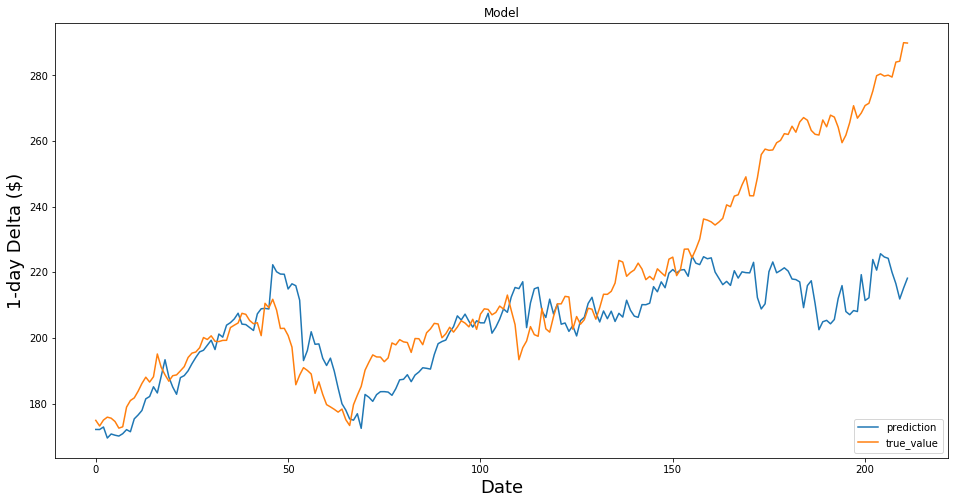

In [24]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('1-day Delta ($)', fontsize=18)
plt.plot(predictFrame)
plt.legend(['prediction', 'true_value'], loc='lower right')
plt.show()